In [3]:
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
import re
import fnmatch
import h5py
import csv
# import seaborn as sns
# sns.set(style='ticks', context='talk') #aesthetics
# plt.style.use("dark_background") #aesthetics

In [4]:
def get_chunk(mm,start,end,channels,sampling_rate=30000):
	duration = end - start
	samples = int(np.round(duration * sampling_rate))
	start_sample = int(start*sampling_rate)*int(channels)
	chunk = mm[start_sample:\
			   start_sample + samples * int(channels)]#int(int(np.floor(np.ceil(end*sampling_rate))*(int(channels))))]
	#print np.shape(chunk)
	return np.reshape(chunk,(int(channels),-1),order='F')  * (0.195)

load events from the patch NWB

In [5]:
slice_nwb_path = np.sort(glob.glob('/Users/danieljdenman/Desktop/cache/meanhwan/2019-06-25_14-59-04/*.nwb'))[0]

In [6]:
d = h5py.File(slice_nwb_path)

In [7]:
TTL0 = np.array([list(d['stimulus']['presentation'][k]['starting_time'])[0] for k in fnmatch.filter(list(d['stimulus']['presentation']), 'data_*_TTL0*')]             )

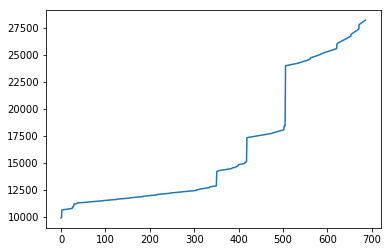

In [8]:
plt.plot(TTL0)

load events from open ephys

In [9]:
import openephys.OpenEphys as oe

In [10]:
glob.glob(os.path.join(os.path.dirname(slice_nwb_path),'*channels*.events'))[0]

'/Users/danieljdenman/Desktop/cache/meanhwan/2019-06-25_14-59-04/experiment1_all_channels_0.events'

In [11]:
npix_events = oe.loadEvents(glob.glob(os.path.join(os.path.dirname(slice_nwb_path),'*channels*.events'))[0])

loading events...


In [12]:
start_time = int(open(glob.glob(os.path.join(os.path.dirname(slice_nwb_path),'*messages*.events'))[0]).readlines()[0].split(' ')[0])/30000.

In [13]:
ch0 = npix_events['timestamps'][npix_events['channel']==0] - start_time

compare the events from the two systems

(0.9, 1.3)

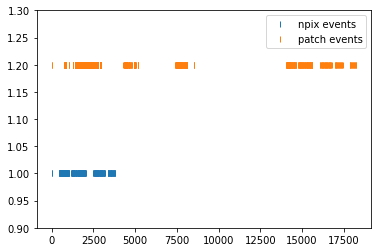

In [35]:
npix_ch0_times = ch0/30000.#ch0[8:][::2]/30000.
patch_ch0_times = TTL0#TTL0[672 - int(len(ch0)/2):671]
plt.plot(npix_ch0_times-npix_ch0_times[0],np.ones(len(npix_ch0_times)),'|',label='npix events')
plt.plot(patch_ch0_times - patch_ch0_times[0],np.ones(len(patch_ch0_times))*1.2,'|',label='patch events')
plt.legend()
plt.ylim(0.9,1.3)
# plt.xlim(2000,2100)

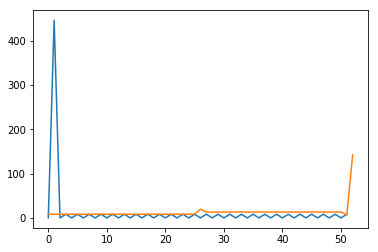

In [33]:
plt.plot(np.diff(npix_ch0_times[:53]))
plt.plot(np.diff(patch_ch0_times[:54]))

# patch_ch0_mask = np.ones(len(patch_ch0_times), dtype=bool)
patch_ch0_mask[52]=False
patch_ch0_mask[53]=False
patch_ch0_redacted = patch_ch0_times[patch_ch0_mask]

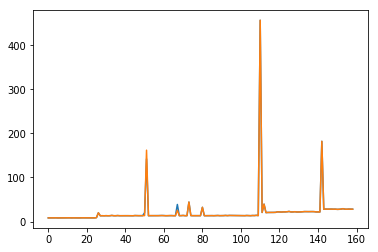

In [17]:
plt.plot(np.diff(npix_ch0_times))
# plt.plot(np.diff(patch_ch0_times[patch_ch0_mask]))
plt.plot(np.diff(patch_ch0_redacted))


approximate number of minutes in the recording:

In [18]:
3500/60.

58.333333333333336

load the neuropixels spike data directtly from kilosort outputs

In [19]:
path = os.path.join(os.path.dirname(slice_nwb_path),'sort1')

In [20]:
os.path.join(path,'spike_clusters.npy')

'/Users/danieljdenman/Desktop/cache/meanhwan/2019-06-25_14-59-04/sort1/spike_clusters.npy'

In [21]:
all_spiketimes = []
all_cluster_numbers = []

clusters_data = np.load(os.path.join(path,'spike_clusters.npy'))
spikes_data = np.load(os.path.join(path,'spike_times.npy'))
spike_templates = np.load(os.path.join(path,'spike_templates.npy'))
templates = np.load(os.path.join(path,'templates.npy'))

cluster_groups = []
[cluster_groups.append(row) for row in csv.reader(open(os.path.join(path,'cluster_group.tsv')))];
spiketime_information = {}
for i in np.arange(1,np.shape(cluster_groups)[0]):
    if cluster_groups[i][0].split('\t')[1] == 'good':           #if it is a 'good' cluster by manual sort
        unit = int(cluster_groups[i][0].split('\t')[0])
        spiketime_information[str(unit)] = {}

        spiketime_information[str(unit)]['spike_times'] = spikes_data[np.where(clusters_data==unit)]/30000.    
        spiketime_information[str(unit)]['spike_times']= spiketime_information[str(unit)]['spike_times'].flatten()

        #get the mean template used for this unit
        all_templates = spike_templates[np.where(clusters_data==unit)].flatten()
        n_templates_to_subsample = 100
        random_subsample_of_templates = templates[all_templates[np.array(np.random.rand(n_templates_to_subsample)*all_templates.shape[0]).astype(int)]]
        mean_template = np.mean(random_subsample_of_templates,axis=0)
        spiketime_information[str(unit)]['template'] = mean_template

        #take a weighted average of the channelmap, where the weights is the absolute value of the template for that channel
        #this gets us the x and y positions of the unit on the probe.
#         if 'channelmap' in kwargs.keys():
#             channelmap = kwargs['channelmap']
#             weights = np.zeros(channelmap.shape)
#             for channel in range(channelmap.shape[0]):
#                 weights[channel,:]=np.trapz(np.abs(mean_template.T[channel,:]))
#             weights = weights/np.max(weights)
#             (xpos,ypos)=np.average(channelmap,axis=0,weights=weights)
#         else:
        (xpos,ypos)=(np.nan,np.nan)
#         spiketime_information[str(unit)]['xpos'] = xpos + 6
#         spiketime_information[str(unit)]['ypos'] = ypos - channelmap[-1][1]

        all_spiketimes.extend(spiketime_information[str(unit)]['spike_times'])
        all_cluster_numbers.extend(np.array(np.ones(len(spiketime_information[str(unit)]['spike_times']))*unit).tolist())



In [22]:
offset = npix_ch0_times[0]-start_time - patch_ch0_times[0]

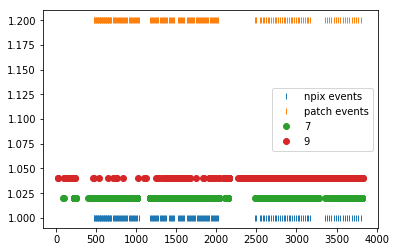

In [23]:
npix_ch0_times = ch0[8:][::2]/30000.
patch_ch0_times = TTL0[672 - int(len(ch0)/2):671]
plt.plot(npix_ch0_times-start_time,np.ones(len(npix_ch0_times)),'|',label='npix events')
plt.plot(patch_ch0_times + offset,np.ones(len(patch_ch0_times))*1.2,'|',label='patch events')
# plt.ylim(0.9,1.3)
for i,cell in enumerate(list(spiketime_information.keys())):
    times_ = spiketime_information[cell]['spike_times']
    plt.plot(times_,np.ones(len(times_))+.02*(i+1),'o',label=cell)
plt.legend()
# plt.xlim(1900,2100)

In [24]:
from braintv_ephys_dev.workstation.danield import psth_and_raster as psth

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f98f00e6390>)

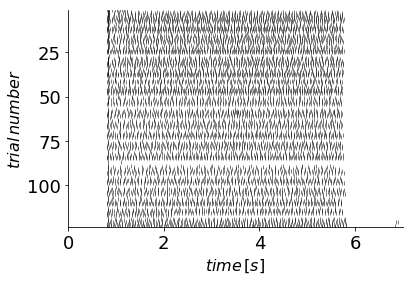

In [25]:
cell='7'
psth.raster(spiketime_information[cell]['spike_times'],npix_ch0_times[26:150]-start_time,
            timeDomain=True,pre=0.,post=7.,color='k',ms=4)

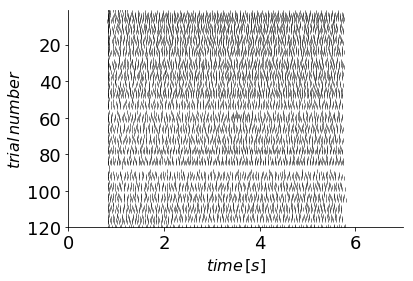

In [28]:
cell='7'
psth.raster(spiketime_information[cell]['spike_times'],npix_ch0_times[26:146]-start_time,
            timeDomain=True,pre=0.,post=7.,color='k',ms=4)
plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','npix_raster.png'),format='png',dpi=600)

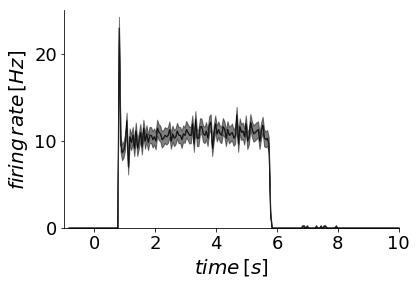

In [29]:
psth.psth_line(spiketime_information[cell]['spike_times'],npix_ch0_times[26:146]-start_time,
            timeDomain=True,pre=1.,post=10.,color='k',error='shaded',ymax=25)
plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','npix_PSTH.png'),format='png',dpi=600)

In [1]:
from braintv_ephys_dev.workstation.danield.generalephys import option234_positions

In [36]:
option234_positions

array([[  21., 3820.],
       [  53., 3820.],
       [   5., 3800.],
       [  37., 3800.],
       [  21., 3780.],
       [  53., 3780.],
       [   5., 3760.],
       [  37., 3760.],
       [  21., 3740.],
       [  53., 3740.],
       [   5., 3720.],
       [  37., 3720.],
       [  21., 3700.],
       [  53., 3700.],
       [   5., 3680.],
       [  37., 3680.],
       [  21., 3660.],
       [  53., 3660.],
       [   5., 3640.],
       [  37., 3640.],
       [  21., 3620.],
       [  53., 3620.],
       [   5., 3600.],
       [  37., 3600.],
       [  21., 3580.],
       [  53., 3580.],
       [   5., 3560.],
       [  37., 3560.],
       [  21., 3540.],
       [  53., 3540.],
       [   5., 3520.],
       [  37., 3520.],
       [  21., 3500.],
       [  53., 3500.],
       [   5., 3480.],
       [  37., 3480.],
       [  21., 3460.],
       [  53., 3460.],
       [   5., 3440.],
       [  37., 3440.],
       [  21., 3420.],
       [  53., 3420.],
       [   5., 3400.],
       [  3

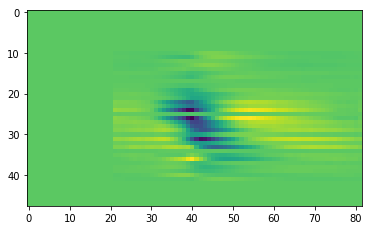

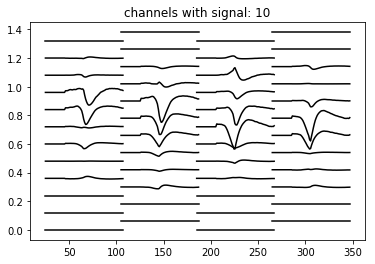

In [681]:
plt.imshow(spiketime_information[cell]['template'].T)
plt.figure()
good = []
for i,ch in enumerate(spiketime_information[cell]['template'].T):
    x_ = option234_positions[::-1][i][0]*5
    y_ = option234_positions[::-1][i][1]
    plt.plot(np.linspace(x_,x_+len(ch),len(ch)),ch+y_*.003,'k')
    if np.max(np.abs(ch)) > 0.05: good.extend([ch])
# plt.ylim(-.2,.1)
plt.title('channels with signal: '+str(len(good)))
plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','npix_template.png'),format='png',dpi=600)

In [309]:
ch3 = np.array([list(d['acquisition']['timeseries'][k]['data']) for k in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD3*')]             )


KeyboardInterrupt: 

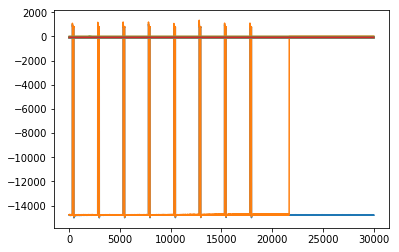

In [358]:
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD10*'):
    temp=np.array(d['acquisition']['timeseries'][tr]['data'])       
    plt.plot(temp[135000:165000])

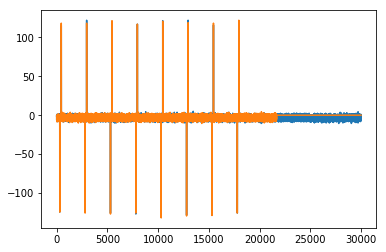

In [359]:
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD9*'):
    temp=np.array(d['acquisition']['timeseries'][tr]['data'])       
    plt.plot(temp[135000:165000])

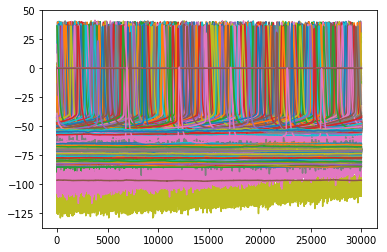

In [360]:
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD11*'):
    temp=np.array(d['acquisition']['timeseries'][tr]['data'])       
    plt.plot(temp[135000:165000])

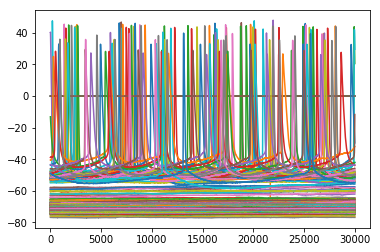

In [311]:
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD3*'):
    temp=np.array(d['acquisition']['timeseries'][tr]['data'])       
    plt.plot(temp[135000:165000])

In [33]:
import matplotlib.mlab as mlab

In [34]:
from matplotlib.mlab import cross_from_below

In [59]:
d['acquisition']['timeseries'][tr]['starting_time'].attrs['rate']

100000.0

In [61]:
pip11_spike_times = []
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD11*'):
    starting_time = np.array(d['acquisition']['timeseries'][tr]['starting_time'])[0]    
    temp=np.array(d['acquisition']['timeseries'][tr]['data'])    
    tts = cross_from_below(temp,0)/d['acquisition']['timeseries'][tr]['starting_time'].attrs['rate'] + starting_time + offset
    pip11_spike_times.extend(tts)

/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The cross_from_below function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  """


In [100]:
pip3_spike_times = []
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD3*'):
    starting_time = np.array(d['acquisition']['timeseries'][tr]['starting_time'])[0]    
    temp=np.array(d['acquisition']['timeseries'][tr]['data'])    
    tts = cross_from_below(temp,0)/d['acquisition']['timeseries'][tr]['starting_time'].attrs['rate'] + starting_time + offset - .252265
    pip3_spike_times.extend(tts)

/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The cross_from_below function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  """


In [142]:
pip3_V = []
pip3_time = []
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD3*'):
    starting_time = np.array(d['acquisition']['timeseries'][tr]['starting_time'])[0]    
    num_samples = np.array(d['acquisition']['timeseries'][tr]['num_samples'])[0]    
    temp=np.array(d['acquisition']['timeseries'][tr]['data']) 
    temp_t = np.linspace(starting_time,starting_time+(num_samples*d['acquisition']['timeseries'][tr]['starting_time'].attrs['rate']),num_samples)
    pip3_V.extend(temp)
    pip3_time.extend(temp_t)
    
    

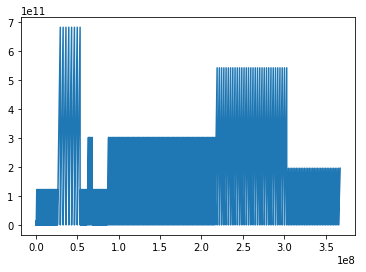

In [146]:
plt.plot(pip3_time)

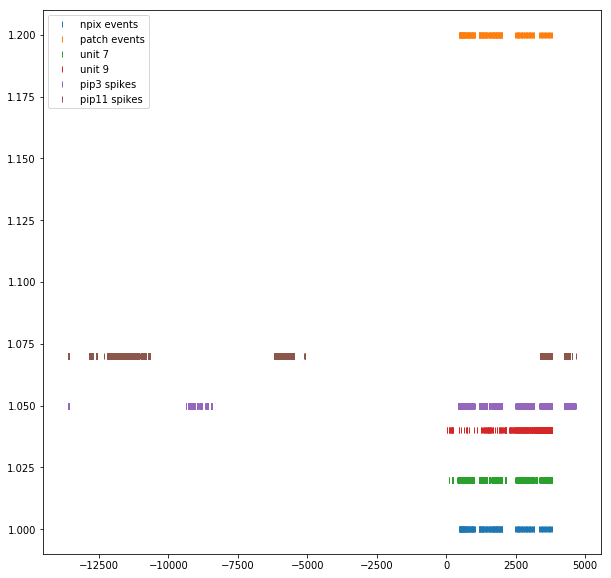

In [147]:
plt.figure(figsize=(10,10))
npix_ch0_times = ch0[8:][::2]/30000. - start_time
patch_ch0_times = TTL0[672 - int(len(ch0)/2):671]+ offset
plt.plot(npix_ch0_times,np.ones(len(npix_ch0_times)),'|',label='npix events')
plt.plot(patch_ch0_times,np.ones(len(patch_ch0_times))*1.2,'|',label='patch events')
# plt.ylim(0.9,1.3)
for i,cell in enumerate(list(spiketime_information.keys())):
    times_ = spiketime_information[cell]['spike_times']
    plt.plot(times_,np.ones(len(times_))+.02*(i+1),'|',label='unit '+cell)
plt.plot(pip3_spike_times,np.ones(len(pip3_spike_times))+.05,'|',label='pip3 spikes')
plt.plot(pip11_spike_times,np.ones(len(pip11_spike_times))+.07,'|',label='pip11 spikes')

plt.legend()
# plt.xlim(1714.15,1714.29)
# plt.xlim(706.5,707)
# plt.xlim(454.663,454.664)
# plt.xlim(3103,3180)
# plt.xlim(687.0392373866653,687.1392373866653)


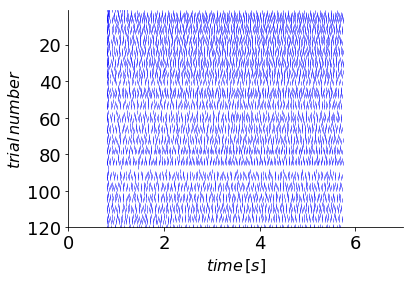

In [149]:
psth.raster(pip3_spike_times,patch_ch0_redacted[26:146]+offset,
            timeDomain=True,pre=0.,post=7.,color='b',ms=4)
plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','pip3_raster.png'),format='png',dpi=600)

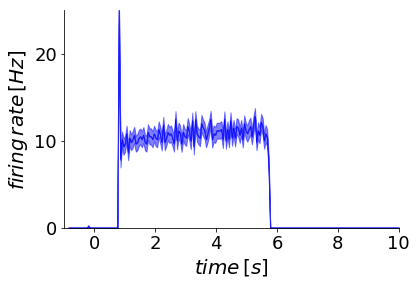

In [152]:
psth.psth_line(pip3_spike_times,patch_ch0_redacted[26:146]+offset,
            timeDomain=True,pre=1.,post=10.,color='b',error='shaded',ymax=25)
plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','pip3_PSTH.png'),format='png',dpi=600)

In [570]:
npix_ch0_times[26:150][0]-start_time

686.0392373866653

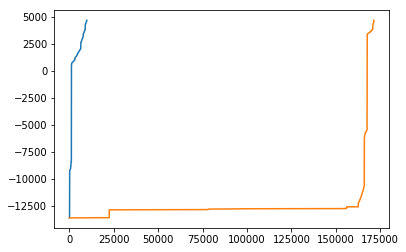

In [101]:
plt.plot(pip3_spike_times)
plt.plot(pip11_spike_times)

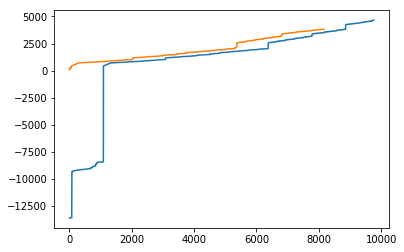

In [450]:
plt.plot(pip3_spike_times)
plt.plot(spiketime_information['7']['spike_times'])

In [73]:
def ccg(train1,train2,binrange,binsize):
    diffs = []
    count=0
    if len(train1) > 1 and len(train2) > 1:
        for spiketime_train1 in train1:
            #for spiketime_train2 in train2:
            if train2[-1] > spiketime_train1 + binrange[0]: # if there are any spikes from train2 after the start of the window 
                start = np.where(train2 > spiketime_train1 + binrange[0])[0][0]

                if train2[-1] > spiketime_train1 + binrange[1]:#set the end of train2 to only relevant window around this spike
                    end = np.where(train2 > spiketime_train1 + binrange[1])[0][0]
                else:
                    end = len(train2)

                for spiketime_train2 in train2[start:end]:
                    diffs.extend([float(spiketime_train1) - float(spiketime_train2)])
                    count+=1
        diffs = np.array(diffs)*-1
        bins = int((binrange[1]-binrange[0])/binsize);print(bins)
        hist,edges = np.histogram(diffs,bins=bins,range=binrange)
        return (hist / float(len(train1)))*100,edges
        #return (hist / float(len(train1)*len(train2) / 2.)  ,edges)
        #return ((hist / (len(train1) * len(train2)) / 2.)*100 * binsize,edges)
    else:
        print('input spiketrains not long enough: 1:'+str(len(train1))+' 2:'+str(len(train2)))
        return [0],[0,0]

In [76]:
ccg_,bins = ccg(pip3_spike_times,spiketime_information['7']['spike_times'],binrange=(-.1,.1),binsize=.001)

200


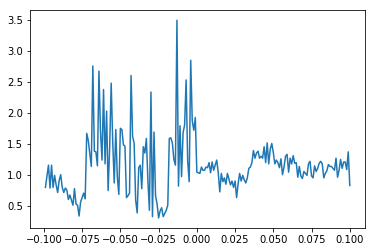

In [77]:
plt.plot(bins[1:],ccg_)

In [89]:
data_path = glob.glob('/Users/danieljdenman/Desktop/cache/meanhwan/2019-06-25_14-59-04/experiment1_10*-0_*.dat')[0]

In [90]:
data_path

'/Users/danieljdenman/Desktop/cache/meanhwan/2019-06-25_14-59-04/experiment1_107-0_0.dat'

In [91]:
mm = np.memmap(data_path, dtype=np.int16, mode='r')

In [102]:
c_start = npix_ch0_times[26:150][0]
c_end = npix_ch0_times[26:150][0]+20

In [109]:
np.where(pip3_spike_times<c_end)

(array([   0,    1,    2, ..., 1307, 1308, 1309]),)

In [103]:
c = get_chunk(mm,c_start,c_end,100)

In [94]:
offset_c = np.mean(c,axis=1)
c_off = (c.transpose()-offset_c).transpose()
med = np.median(c_off[:20],axis=0)
data = c_off-med

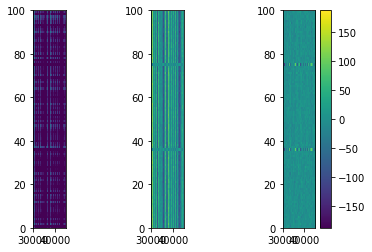

In [95]:
f,ax = plt.subplots(1,3)
ax[0].imshow(c);
ax[1].imshow(c_off);
cbar = ax[2].imshow(data);
for axi in ax:
    axi.set_aspect(1000)
    axi.set_xlim(30000,45000)
    axi.set_ylim(0,100)
    axi.get_images()[0].set_clim(cbar.get_clim())
plt.colorbar(cbar)

In [137]:
pip3_onnpixsampleclock = np.array([int((pip3_spike_times[i]-c_start)*30000) for i in np.intersect1d(np.where(pip3_spike_times>c_start),np.where(pip3_spike_times<c_end))])

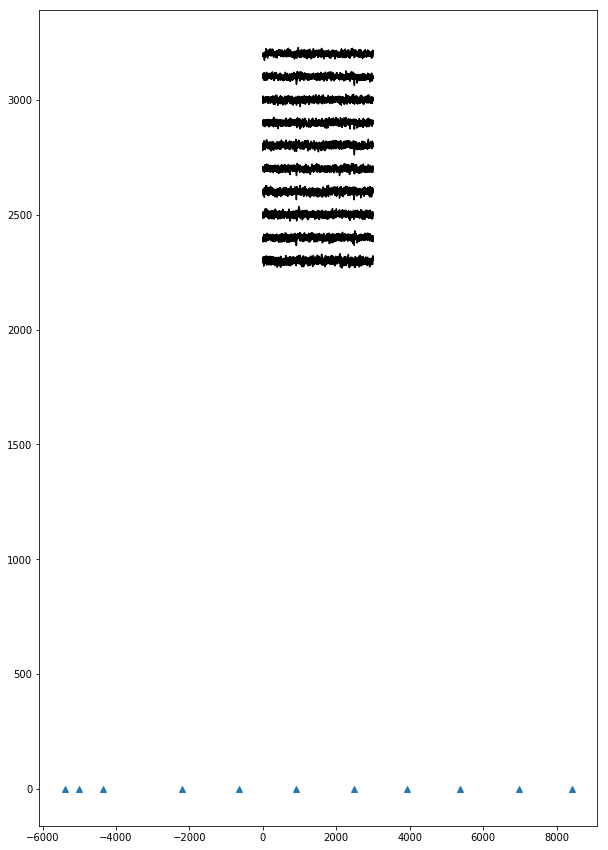

In [138]:
x=30000#start 1 second in
plt.figure(figsize=(10,15))
for ch in np.arange(23,33):
    plt.plot(data[ch][x:x+3000]+ch*100,'k')
plt.plot(pip3_onnpixsampleclock-x, np.ones(len(pip3_onnpixsampleclock)),'^')

In [604]:
trials = []
starttime = []
for tr in fnmatch.filter(list(d['acquisition']['timeseries']), 'data_*_AD3*'):
    starting_time = np.array(d['acquisition']['timeseries'][tr]['starting_time'])[0]    
    starttime.extend([starting_time+offset])
    trials.extend([np.array(d['acquisition']['timeseries'][tr]['data'])])

(1.0, 1.1)

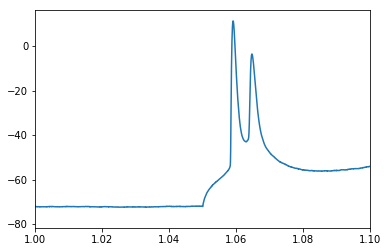

In [703]:
sweep = trials[np.where(starttime>npix_ch0_times[26:150][0]-0.1-start_time)[0][1]]
plt.plot(np.linspace(0,len(sweep)/200000.,len(sweep)),
         sweep)
plt.xlim(1.,1.1)
# plt.gcf().savefig(os.path.join('/Users/danieljdenman/Dropbox/allenTransfer/invitropanels','pip3_spike.png'),format='png',dpi=600)

NameError: name 'sweep' is not defined

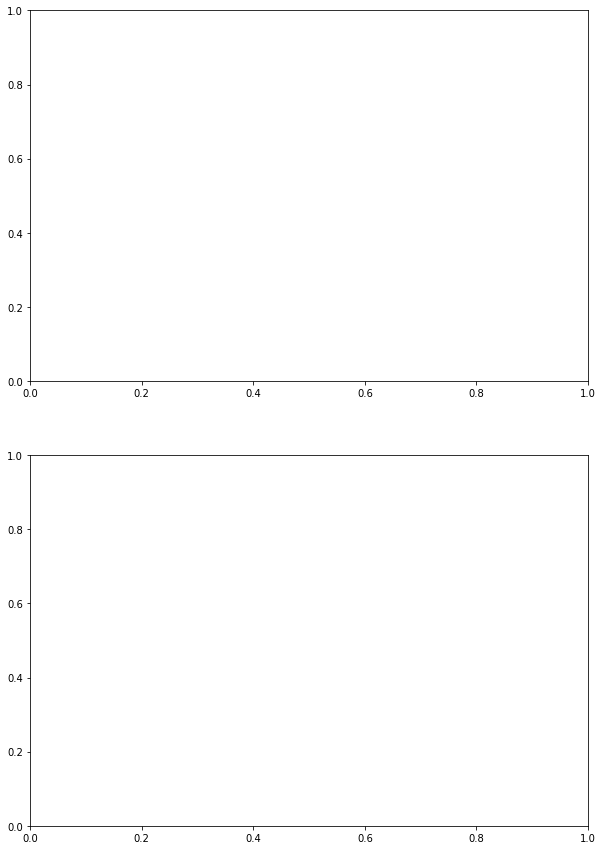

In [97]:
x=20000#start 1 second in
f,ax = plt.subplots(2,1,figsize=(10,15))
ax[0].plot(np.linspace(0,len(sweep)/200000.,len(sweep)),sweep)
for ch in np.arange(23,28):
    ax[1].plot(data[ch][x:x+30000]+ch*100,'k')

In [590]:
pip11_spike_times[np.where(pip11_spike_times>npix_ch0_times[26:150][0]-start_time)[0]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [10]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [12]:
def f(x,data):
    if x < data.shape[1]-1000:
        plt.figure(figsize=(10,20))
        for ch in range(40):
            plt.plot(data[ch][x:x+1000]+ch*100,'k')
        plt.show()

In [52]:
x=17000
interactive_plot = interactive(f, x=x, data=fixed(data))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot
# interact(f, x=32000, data=fixed(data));

TypeError: 'Figure' object is not callable

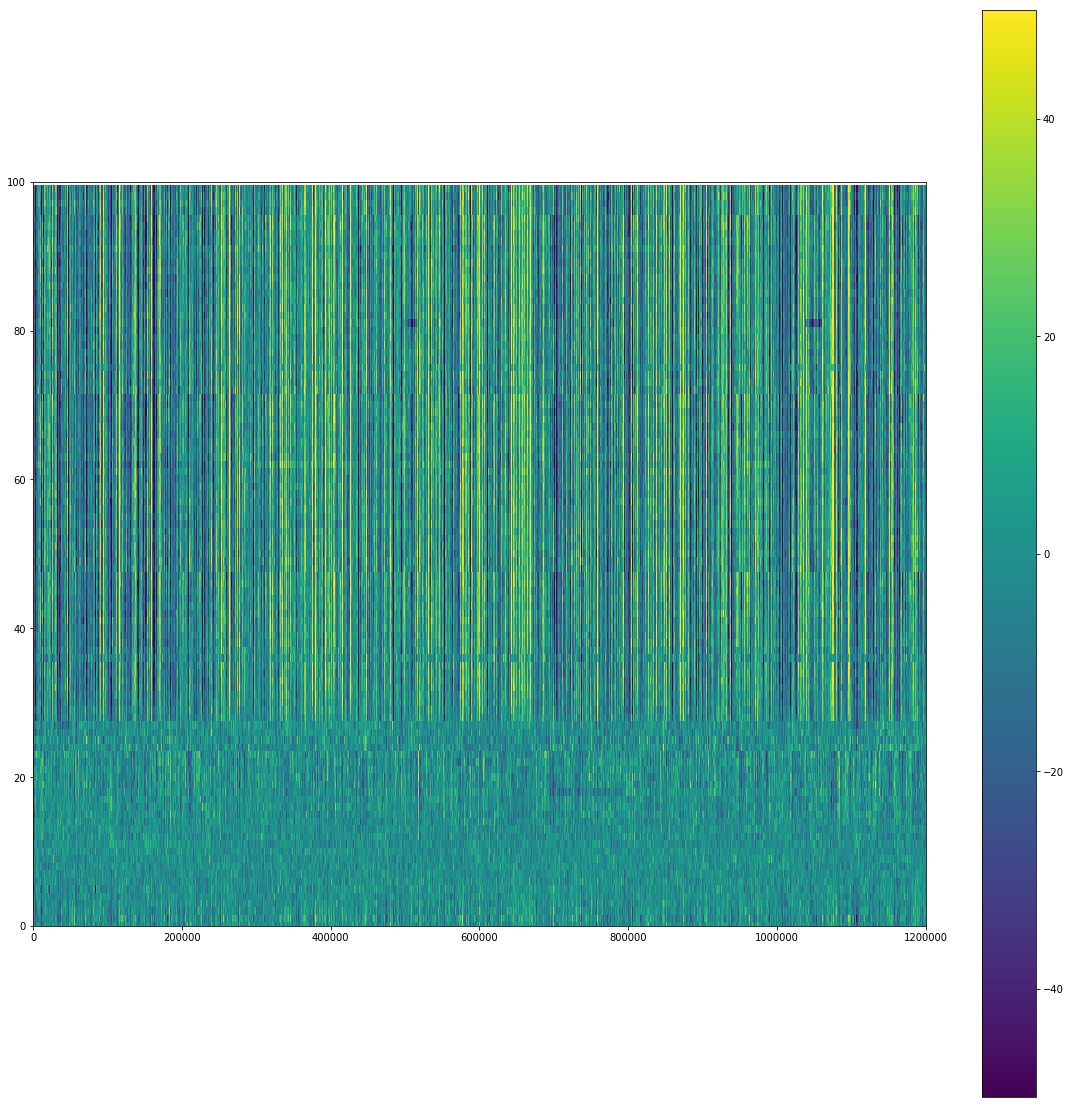

In [256]:
plt.figure(figsize=(20,20))
cbar = plt.imshow(data,clim=(-50,50));
plt.gca().set_aspect(10000.)
plt.ylim(0,100)
# plt.xlim(250000,300000)
plt.colorbar()
plt.gcf().savefig('raw_chunk.eps',format='eps')

In [23]:
np.arange(20,30)

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [210]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
xs=200885

In [246]:
xs = plt.mlab.cross_from_above(data[19],-40)

/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The cross_from_above function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  """Entry point for launching an IPython kernel.


In [247]:
np.shape(xs)

(340,)

In [248]:
np.shape(data[:,x-10:x+20])

(100, 30)

In [252]:
all_w = np.zeros((100,30,np.shape(xs)[0]))
for i,x in enumerate(xs):
    all_w[:,:,i] = data[:,x-10:x+20]
    

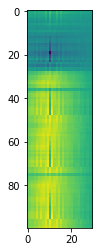

In [253]:
plt.imshow(np.mean(all_w,axis=2))

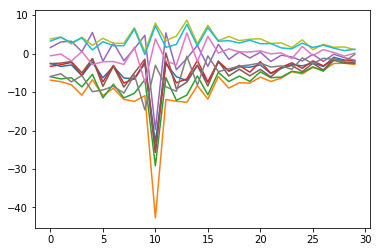

In [254]:
m=np.mean(all_w,axis=2)
for ch in np.arange(18,28):
    plt.plot(m[ch])

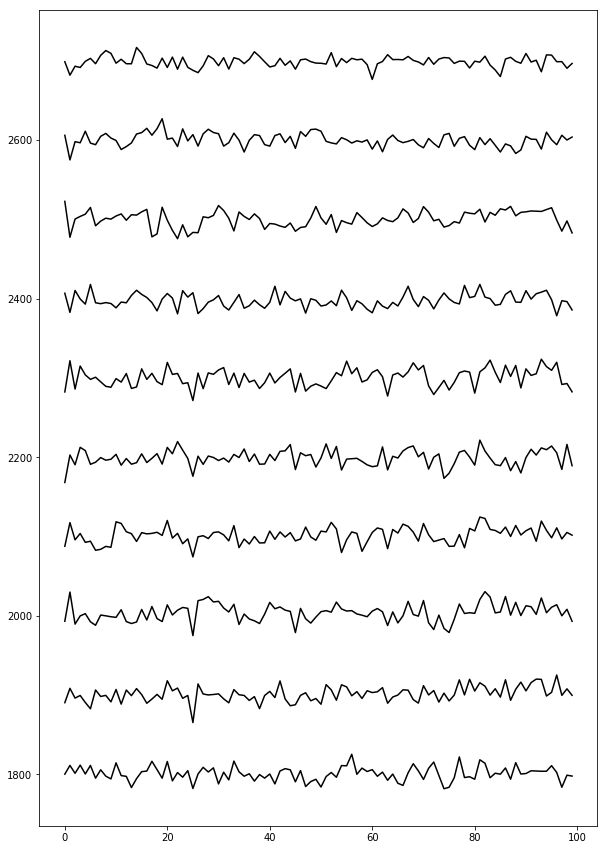

In [225]:
x=200885
plt.figure(figsize=(10,15))
for ch in np.arange(18,28):
    plt.plot(data[ch][x-25:x+75]+ch*100,'k')

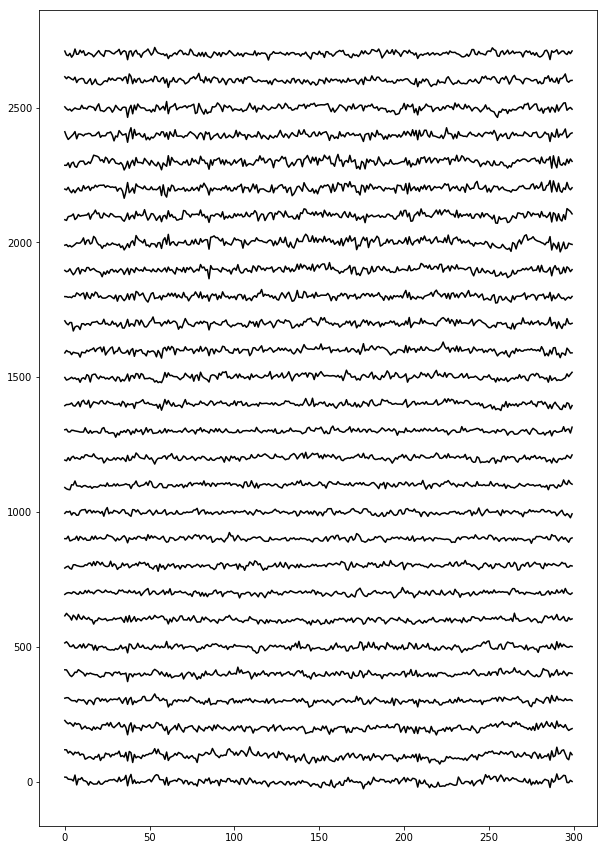

In [263]:
x=200800
# for add in range(10):
plt.figure(figsize=(10,15))
for ch in np.arange(0,28):
    plt.plot(data[ch][x:x+300]+ch*100,'k')
plt.gcf().savefig('raw_traces_example.png',format='png')